# Predicting House Sale Prices

In this project, I practice what I learned about approaches to model fitting, and techniques for cleaning, transforming, and selecting features by exploring ways to improve the linear regression model built in the course of Linear Regression for Machine Learning.  I also experiment with different k-fold to achieve the optimal LinearRegression model.

I'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can also read about the different columns in the data _[here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)_.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


In [2]:
housing = pd.read_csv('AmesHousing.tsv', delimiter='\t')
#housing.head()

df = housing.copy()
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Initial Model

In [3]:
def transform_features(df):
    return df

def select_features(df):
    cols =  ['Gr Liv Area','SalePrice']
    return df[cols]

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    
    #select numeric columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])  
    numeric_test = test.select_dtypes(include=['integer', 'float'])

    features = numeric_train.columns.drop('SalePrice')
    
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))  
    return rmse

transformed_df = transform_features(df)
filtered_df = select_features(transformed_df)
rmse = train_and_test(filtered_df)
print(rmse)    

57088.25161263909


### Transforming Features


##### 1: Drop columns from the data frame with more than 5% missing values.



In [4]:
df.shape


(2930, 82)

In [6]:
# filter series with more than 5% missing value count
null_counts = df.isnull().sum()
cols_5pct_mv = null_counts[null_counts > len(df)/20].sort_values()    
print(cols_5pct_mv)
df = df.drop(cols_5pct_mv.index, axis=1)   
df.shape


Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Qual       159
Garage Cond       159
Lot Frontage      490
Fireplace Qu     1422
Fence            2358
Alley            2732
Misc Feature     2824
Pool QC          2917
dtype: int64


(2930, 71)

##### 2: Text columns: Drop any with 1 or more missing values for now.



In [7]:
# drop tex columns with 1 or more missing values
text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)     
df = df.drop(text_mv_counts[text_mv_counts > 0].index, axis=1)
df.shape


(2930, 64)

##### 3: Numerical columns: For columns with missing values, fill in with the most common value in that column



In [8]:
# compute numerical column-wise missing value count
num_mv_counts = df.select_dtypes(include=['int', 'float']).isnull().sum()     

cols_num_mv  = num_mv_counts[(num_mv_counts < len(df)/20) & (num_mv_counts > 0)].sort_values()
cols_num_mv
  

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [9]:
# replacement value
most_common_value_dict = df[cols_num_mv.index].mode().to_dict(orient='records')[0]     
most_common_value_dict


{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [10]:
# fill missing value in numeric column with replacement 
# of most common value repectively
df = df.fillna(most_common_value_dict)



Verify every column has no missing value

In [11]:
df.isnull().sum().value_counts()



0    64
dtype: int64

##### 4: Create new features that better capture information in some features



In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 64 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       29

In [13]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [14]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']  
years_since_remod[years_since_remod < 0]


1702   -1
2180   -2
2181   -1
dtype: int64

In [15]:
# create new column
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

# drop rows with negative values for both new features
df = df.drop([1702, 2180, 2181], axis=0)

# drop original columns no long used
df = df.drop(['Year Remod/Add', 'Year Built'], axis=1)

df.shape


(2927, 64)

##### 5: Drop features that aren't useful for machine learning or leak infomation about the sale



In [16]:
# Drop columns that are not useful for machine learning
df = df.drop(['PID', 'Order'], axis=1)

# Drop columns that leak info about final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)   

df.shape


(2927, 58)

##### 6: Update transform_features() function:

- Drop any column from the data frame with more than 5% (or another cutoff value) missing values 
- Remove features not used in the model, just based on the number of missing values or data leakage
- Fill in missing values with most common value
- Create new features by combining other features



In [42]:
def transform_features(df):
    # filter series with more than 5% missing value count
    null_counts = df.isnull().sum()
    cols_5pct_mv = null_counts[null_counts > len(df)/20].sort_values()    
    df = df.drop(cols_5pct_mv.index, axis=1) 
    
    # drop tex columns with 1 or more missing values
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)    
    df = df.drop(text_mv_counts[text_mv_counts > 0].index, axis=1)

    # compute numerical column-wise missing value count
    num_mv_counts = df.select_dtypes(include=['int', 'float']).isnull().sum()     
    cols_num_mv  = num_mv_counts[(num_mv_counts < len(df)/20) & (num_mv_counts > 0)].sort_values()  
    # replacement value of the most common value
    most_common_value_dict = df[cols_num_mv.index].mode().to_dict(orient='records')[0]     
    # fill missing value in numeric column with replacement 
    # of most common value repectively
    df = df.fillna(most_common_value_dict)
    
    # create new features
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']  

    # drop rows with negative values for both new features
    df = df.drop([1702, 2180, 2181], axis=0)

    # drop original columns no long used or not useful 
    # for ml, or leak info for final sales
    df = df.drop(['Year Remod/Add', 'Year Built', 'PID', 'Order', "Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return df

def select_features(df):
    cols =  ['Gr Liv Area','SalePrice']
    return df[cols]

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    
    #select numeric columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])  
    numeric_test = test.select_dtypes(include=['integer', 'float'])

    features = numeric_train.columns.drop('SalePrice')
    
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))  
    return rmse

df = housing.copy()
transformed_df = transform_features(df)
filtered_df = select_features(transformed_df)
rmse = train_and_test(filtered_df)
print(rmse)    

55275.36731241307


### Feature Selection



##### 1: Investigete numerical column correlation with 'SalePrice'.  Only keep numerical columns with correlation coefficient greater than 0.4.


In [43]:
# select numerical columns
numerical_df = transformed_df.select_dtypes(include=['int', 'float'])     
numerical_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 33 columns):
MS SubClass          2927 non-null int64
Lot Area             2927 non-null int64
Overall Qual         2927 non-null int64
Overall Cond         2927 non-null int64
Mas Vnr Area         2927 non-null float64
BsmtFin SF 1         2927 non-null float64
BsmtFin SF 2         2927 non-null float64
Bsmt Unf SF          2927 non-null float64
Total Bsmt SF        2927 non-null float64
1st Flr SF           2927 non-null int64
2nd Flr SF           2927 non-null int64
Low Qual Fin SF      2927 non-null int64
Gr Liv Area          2927 non-null int64
Bsmt Full Bath       2927 non-null float64
Bsmt Half Bath       2927 non-null float64
Full Bath            2927 non-null int64
Half Bath            2927 non-null int64
Bedroom AbvGr        2927 non-null int64
Kitchen AbvGr        2927 non-null int64
TotRms AbvGrd        2927 non-null int64
Fireplaces           2927 non-null int64
Garage Cars       

In [44]:
# check correlation of columns to 'SalePrice'
abs_corr_coef_to_SalePrice = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)      
abs_corr_coef_to_SalePrice


SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: Sale

In [45]:
# only keep column with correlation coefficient > 0.4
abs_corr_coef_to_SalePrice[abs_corr_coef_to_SalePrice > .4]        


SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Name: SalePrice, dtype: float64

In [46]:
# Drop columns with corr coefficient less than 0.4
transformed_df = transformed_df.drop(abs_corr_coef_to_SalePrice[abs_corr_coef_to_SalePrice < .4].index, axis=1) 

transformed_df.shape


(2927, 39)

##### 2: Generate heatmap of strong correlation columns to 'SalePrice'.   Are there columns having strong correlation to each other which indicates duplicate infomation?


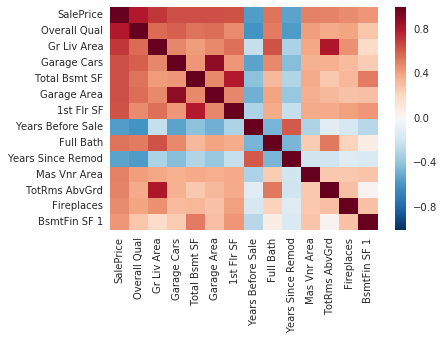

In [52]:
strong_corrs = abs_corr_coef_to_SalePrice[abs_corr_coef_to_SalePrice > .4]     
corr_matrix = transformed_df[strong_corrs.index].corr()
sns.heatmap(corr_matrix)
plt.show()


Strong correlated pair:
'Garage Areas' and 'Garage Car',
'1st Flr SF' and 'Total Bsmt SF',
'TotRms AbvGrd', 'Gr Liv Area'


In [53]:
# drop collinearity pair
transformed_df = transformed_df.drop(['Garage Area', '1st Flr SF', 'TotRms AbvGrd'], axis=1)    
transformed_df.shape



(2927, 36)

##### 3: Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?

In [56]:
num_cols = transformed_df.select_dtypes(include=['int', 'float']).info()
num_cols


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 11 columns):
Overall Qual         2927 non-null int64
Mas Vnr Area         2927 non-null float64
BsmtFin SF 1         2927 non-null float64
Total Bsmt SF        2927 non-null float64
Gr Liv Area          2927 non-null int64
Full Bath            2927 non-null int64
Fireplaces           2927 non-null int64
Garage Cars          2927 non-null float64
SalePrice            2927 non-null int64
Years Before Sale    2927 non-null int64
Years Since Remod    2927 non-null int64
dtypes: float64(4), int64(7)
memory usage: 274.4 KB


In [58]:
transformed_df['Garage Cars'].head()

0    2.0
1    1.0
2    1.0
3    2.0
4    2.0
Name: Garage Cars, dtype: float64

In [63]:
# It seems 'Garage Cars' columns currently is numerical 
# but needs to be encoded as categorical
transformed_df['Garage Cars'] = transformed_df['Garage Cars'].astype('int').astype('category')
transformed_df['Garage Cars'].head()


0    2
1    1
2    1
3    2
4    2
Name: Garage Cars, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

##### 4: Exam what categorical columns to keep ( those with unique value counts less than 10)


In [78]:
# Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]


In [79]:
transformed_df.columns


Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Roof Style', 'Roof Matl',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Gr Liv Area', 'Full Bath', 'Kitchen Qual', 'Functional', 'Fireplaces',
       'Garage Cars', 'Paved Drive', 'SalePrice', 'Years Before Sale',
       'Years Since Remod'],
      dtype='object')

In [80]:
# Which categorical columns are still in transformed_df
transformed_cat_col = []
for col in transformed_df.columns:
    if col in nominal_features:
        transformed_cat_col.append(col)
        
transformed_cat_col        


['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Foundation',
 'Heating',
 'Central Air']

In [81]:
# how many unique values in each nominal columns
uniqueness_counts = transformed_df[transformed_cat_col].apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts


Street          2
Central Air     2
Land Contour    4
Lot Config      5
Bldg Type       5
Roof Style      6
Foundation      6
Heating         6
MS Zoning       7
Condition 2     8
House Style     8
Roof Matl       8
Condition 1     9
dtype: int64

In [82]:
# Drop off column with unique counts of more than 10
uniqueness_counts_gt_10 = uniqueness_counts[uniqueness_counts > 10]    
transformed_df = transformed_df.drop(uniqueness_counts_gt_10.index, axis=1)
transformed_df.shape


(2927, 33)

##### 5: Which categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category? This would be similar to a low variance numerical feature (no variability in the data for the model to capture).

In [100]:
transformed_df['Street'].value_counts()

Pave    2915
Grvl      12
Name: Street, dtype: int64

In [101]:
transformed_df['Condition 2'].value_counts()

Norm      2898
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition 2, dtype: int64

In [99]:
transformed_df['Roof Matl'].value_counts()
    


CompShg    2884
Tar&Grv      23
WdShake       9
WdShngl       7
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: Roof Matl, dtype: int64

In [102]:
transformed_df['Heating'].value_counts()

GasA     2882
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

In [103]:
# Drop low variance columns
transformed_df = transformed_df.drop(['Street', 'Condition 2', 'Roof Matl', 'Heating'], axis=1)    
transformed_df.shape


(2927, 29)

##### 6. Get dummies columns for remaining categorical columns


In [104]:
# Select the remaining text columns and convert them to 
# categorical
text_cols = transformed_df.select_dtypes(include=['object'])  
for col in text_cols:
    transformed_df[col] = transformed_df[col].astype('category')    

# Create dummy columns and add it back to dataframe
dummy_cols = pd.get_dummies(transformed_df.select_dtypes(include=['category']))     
         
transformed_df = pd.concat([transformed_df, dummy_cols], axis=1)

# Drop original text columns
#transformed_df = transformed_df.drop(text_cols, axis=1)

transformed_df.shape


(2927, 127)

##### 7: Update select_features() function:

 - Drop numberical columns whose correlation coefficient to 'SalePrice' is less than 0.4 
 - Drop categorical columns whose unique value counts is greater than 10
 - Get dummy columns for those remaining categorical columns
 

In [106]:
def transform_features(df):
    # filter series with more than 5% missing value count
    null_counts = df.isnull().sum()
    cols_5pct_mv = null_counts[null_counts > len(df)/20].sort_values()    
    df = df.drop(cols_5pct_mv.index, axis=1) 
    
    # drop tex columns with 1 or more missing values
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)    
    df = df.drop(text_mv_counts[text_mv_counts > 0].index, axis=1)

    # compute numerical column-wise missing value count
    num_mv_counts = df.select_dtypes(include=['int', 'float']).isnull().sum()     
    cols_num_mv  = num_mv_counts[(num_mv_counts < len(df)/20) & (num_mv_counts > 0)].sort_values()  
    # replacement value of the most common value
    most_common_value_dict = df[cols_num_mv.index].mode().to_dict(orient='records')[0]     
    # fill missing value in numeric column with replacement 
    # of most common value repectively
    df = df.fillna(most_common_value_dict)
    
    # create new features
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']  

    # drop rows with negative values for both new features
    df = df.drop([1702, 2180, 2181], axis=0)

    # drop original columns no long used or not useful 
    # for ml, or leak info for final sales
    df = df.drop(['Year Remod/Add', 'Year Built', 'PID', 'Order', "Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return df

def select_features(df):
    # select numerical columns
    numerical_df = df.select_dtypes(include=['int', 'float'])     
    # check correlation of columns to 'SalePrice'
    abs_corr_coef_to_SalePrice = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)      
    # only keep column with correlation coefficient > 0.4
    abs_corr_coef_to_SalePrice[abs_corr_coef_to_SalePrice > .4]        
    # Drop columns with corr coefficient less than 0.4
    df = df.drop(abs_corr_coef_to_SalePrice[abs_corr_coef_to_SalePrice < .4].index, axis=1) 
    
    # drop collinearity pair
    df = df.drop(['Garage Area', '1st Flr SF', 'TotRms AbvGrd'], axis=1)    
    # It seems 'Garage Cars' columns currently is numerical 
    # but needs to be encoded as categorical
    df['Garage Cars'] = df['Garage Cars'].astype('int').astype('category')

    # Create a list of column names from documentation that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    # Which categorical columns are still in transformed_df
    cat_col = []
    for col in df.columns:
        if col in nominal_features:
            cat_col.append(col)
    # how many unique values in each nominal columns
    uniqueness_counts = df[cat_col].apply(lambda col: len(col.value_counts())).sort_values()
    # Drop off column with unique counts of more than 10
    uniqueness_counts_gt_10 = uniqueness_counts[uniqueness_counts > 10]    
    df = df.drop(uniqueness_counts_gt_10.index, axis=1)
    
    # Drop low variance columns
    df = df.drop(['Street', 'Condition 2', 'Roof Matl', 'Heating'], axis=1)    
    
    # Select the remaining text columns and convert them to 
    # categorical
    text_cols = df.select_dtypes(include=['object'])  
    for col in text_cols:
        df[col] = df[col].astype('category')    

    # Create dummy columns and add it back to dataframe
    dummy_cols = pd.get_dummies(df.select_dtypes(include=['category']))     
    df = pd.concat([df, dummy_cols], axis=1)

    # Drop original text columns
    #df = df.drop(text_cols, axis=1)

    return df

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    
    #select numeric columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])  
    numeric_test = test.select_dtypes(include=['integer', 'float'])

    features = numeric_train.columns.drop('SalePrice')
    
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))  
    return rmse      
    
df = housing.copy()
transformed_df = transform_features(df)
filtered_df = select_features(transformed_df)
rmse = train_and_test(filtered_df)
print(rmse)    

31830.233441368862


### Build best fitting model with k-folds cross validation

In [22]:
def transform_features(df):
    # filter series with more than 5% missing value count
    null_counts = df.isnull().sum()
    cols_5pct_mv = null_counts[null_counts > len(df)/20].sort_values()    
    df = df.drop(cols_5pct_mv.index, axis=1) 
    
    # drop tex columns with 1 or more missing values
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)    
    df = df.drop(text_mv_counts[text_mv_counts > 0].index, axis=1)

    # compute numerical column-wise missing value count
    num_mv_counts = df.select_dtypes(include=['int', 'float']).isnull().sum()     
    cols_num_mv  = num_mv_counts[(num_mv_counts < len(df)/20) & (num_mv_counts > 0)].sort_values()  
    # replacement value of the most common value
    most_common_value_dict = df[cols_num_mv.index].mode().to_dict(orient='records')[0]     
    # fill missing value in numeric column with replacement 
    # of most common value repectively
    df = df.fillna(most_common_value_dict)
    
    # create new features
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']  

    # drop rows with negative values for both new features
    df = df.drop([1702, 2180, 2181], axis=0)

    # drop original columns no long used or not useful 
    # for ml, or leak info for final sales
    df = df.drop(['Year Remod/Add', 'Year Built', 'PID', 'Order', "Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return df

def select_features(df):
    # select numerical columns
    numerical_df = df.select_dtypes(include=['int', 'float'])     
    # check correlation of columns to 'SalePrice'
    abs_corr_coef_to_SalePrice = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)      
    # only keep column with correlation coefficient > 0.4
    abs_corr_coef_to_SalePrice[abs_corr_coef_to_SalePrice > .4]        
    # Drop columns with corr coefficient less than 0.4
    df = df.drop(abs_corr_coef_to_SalePrice[abs_corr_coef_to_SalePrice < .4].index, axis=1) 
    
    # drop collinearity pair
    df = df.drop(['Garage Area', '1st Flr SF', 'TotRms AbvGrd'], axis=1)    
    # It seems 'Garage Cars' columns currently is numerical 
    # but needs to be encoded as categorical
    df['Garage Cars'] = df['Garage Cars'].astype('int').astype('category')

    # Create a list of column names from documentation that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    # Which categorical columns are still in transformed_df
    cat_col = []
    for col in df.columns:
        if col in nominal_features:
            cat_col.append(col)
    # how many unique values in each nominal columns
    uniqueness_counts = df[cat_col].apply(lambda col: len(col.value_counts())).sort_values()
    # Drop off column with unique counts of more than 10
    uniqueness_counts_gt_10 = uniqueness_counts[uniqueness_counts > 10]    
    df = df.drop(uniqueness_counts_gt_10.index, axis=1)
    
    # Drop low variance columns
    df = df.drop(['Street', 'Condition 2', 'Roof Matl', 'Heating'], axis=1)    
    
    # Select the remaining text columns and convert them to 
    # categorical
    text_cols = df.select_dtypes(include=['object'])  
    for col in text_cols:
        df[col] = df[col].astype('category')    

    # Create dummy columns and add it back to dataframe
    dummy_cols = pd.get_dummies(df.select_dtypes(include=['category']))     
    df = pd.concat([df, dummy_cols], axis=1)

    # Drop original text columns
    #df = df.drop(text_cols, axis=1)

    return df

def train_and_test(df, k=0):
    #select numeric columns
    numeric_df = df.select_dtypes(include=['integer', 'float'])  
    features = numeric_df.columns.drop('SalePrice')
    # initiate model
    lr = LinearRegression()
    
    if k == 0:
        train = df[0:1460]
        test = df[1460:]
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'], predictions)
        rmse = rmse = np.sqrt(mse)
        return rmse

    if k == 1:
        # shuffle all rows 
        shuffled_df = df.sample(frac=1,)
        fold_one = df[0:1460]
        fold_two = df[1460:]
        # Train on fold_one and test on fold_two
        lr.fit(fold_one[features], fold_one['SalePrice'])
        predictions = lr.predict(fold_two[features])
        mse = mean_squared_error(fold_two['SalePrice'], predictions)
        rmse_one = rmse = np.sqrt(mse)
        # Train on fold_two and test on fold_one
        lr.fit(fold_two[features], fold_two['SalePrice'])
        predictions = lr.predict(fold_one[features])
        mse = mean_squared_error(fold_one['SalePrice'], predictions)
        rmse_two = rmse = np.sqrt(mse)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train['SalePrice'])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test['SalePrice'], predictions)
            rmse = rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
  
df = housing.copy()
transformed_df = transform_features(df)
filtered_df = select_features(transformed_df)
filtered_df.to_csv('filtered_df.csv')

avg_rmse_values = []
for K in range(9):
    rmse = train_and_test(filtered_df, k=K)
    print('k={} avg_rmse={}'.format(K, rmse))
    avg_rmse_values.append(rmse)


k=0 avg_rmse=31830.233441368862
k=1 avg_rmse=29368.360978955745
[31295.321540196735, 27855.94086299145]
k=2 avg_rmse=29575.631201594093
[33880.9912680786, 24030.719643129505, 26553.032067159653]
k=3 avg_rmse=28154.914326122587
[27521.185911297747, 34359.247715819714, 27022.680111736816, 24152.98795205541]
k=4 avg_rmse=28264.02542272742
[25796.886173517152, 25510.967784659526, 25626.733379018857, 38247.0722307317, 24005.816019714617]
k=5 avg_rmse=27837.49511752837
[27789.831614081926, 25178.189694443914, 26233.724318410335, 37935.809143050035, 26369.57246438806, 26345.533440347972]
k=6 avg_rmse=28308.77677912037
[29402.765366501564, 27947.97444696205, 21214.361876446408, 23632.703258415928, 26399.48103533483, 24114.282178919537, 41056.72163132028]
k=7 avg_rmse=27681.184256271514
[24242.980991224245, 24859.3337860343, 24567.252998189033, 28445.04139900053, 30613.772617983697, 23720.897371826668, 41235.98894330403, 26711.590684346163]
k=8 avg_rmse=28049.607348988582


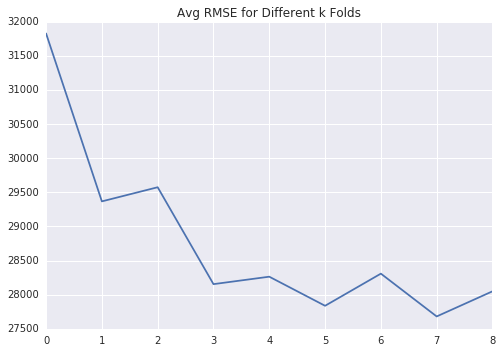

In [23]:
# plot avg_rmse for different k folds
k_values = [k for k in range(9)]
plt.plot(k_values, avg_rmse_values)
plt.title('Avg RMSE for Different k Folds')


As it can be seen, as k folds increases, Average RMSE decreases.  After k reaches 7 or 8, there is not much significient improvement to average RMSE. 